# Degree distribution

## Import statements

In [ ]:
import time
import networkx as nx
import numpy as np

from typing import List
import dfg_rating.viz.jupyter_widgets as DFGWidgets
from dfg_rating.model.network.base_network import BaseNetwork
from dfg_rating.model.network.random_network import ConfigurationModelNetwork
from dfg_rating.model.rating.controlled_trend_rating import ControlledTrendRating, ControlledRandomFunction
from dfg_rating.model.rating.elo_rating import ELORating


from dfg_rating.model.evaluators.accuracy import RankProbabilityScore, Likelihood
from dfg_rating.model.forecast.true_forecast import LogFunctionForecast

from dfg_rating.viz.tables import get_evaluation

## Data Generation

In [ ]:
in_degree = 120
out_degree = 120
initial_variance = 0
maximum_variance = 150
variance_step = 2

### Example network

In [ ]:
example_network = ConfigurationModelNetwork(
    teams=200,
    days_between_rounds=3,
    true_rating=ControlledTrendRating(
        starting_point=ControlledRandomFunction(distribution='normal', loc=1000, scale=100),
        delta=ControlledRandomFunction(distribution='normal', loc=0, scale=3),
        trend=ControlledRandomFunction(distribution='normal', loc=0, scale=20/365),
        season_delta=ControlledRandomFunction(distribution='normal', loc=0, scale=10)
    ),
    expected_home_matches=in_degree,
    expected_away_matches=out_degree,
    variance_home_matches=initial_variance + 50,
    variance_away_matches=initial_variance + 50
)

In [ ]:
len(example_network.data.edges())

In [ ]:
app = DFGWidgets.NetworkExplorer(network=example_network)

In [ ]:
example_network.density(True)

In [ ]:
app.run('inline', port=8002)

### Range of networks

In [ ]:
networks_list: List[BaseNetwork] = []

In [ ]:
variance_range = range(initial_variance, maximum_variance + 1, variance_step)
for variance in variance_range:
    start_time = time.time()
    networks_list.append(
        ConfigurationModelNetwork(
            teams=50,
            days_between_rounds=3,
            true_forecast=LogFunctionForecast(
                outcomes=['home', 'draw', 'away'],
                coefficients = [-0.9,0.3],
                beta_parameter=0.006
            ),
            true_rating=ControlledTrendRating(
                starting_point=ControlledRandomFunction(distribution='normal', loc=1000, scale=100),
                delta=ControlledRandomFunction(distribution='normal', loc=0, scale=3),
                trend=ControlledRandomFunction(distribution='normal', loc=0, scale=20/365),
                season_delta=ControlledRandomFunction(distribution='normal', loc=0, scale=10)
            ),
            expected_home_matches=in_degree,
            expected_away_matches=out_degree,
            variance_home_matches=variance,
            variance_away_matches=variance
        )
    )
    print(np.var([t[1] for t in networks_list[-1].degree(True)]))
    print(f"Added network with Degree variance of {variance} in {time.time() -  start_time} seconds.")

### Evaluation metrics

In [ ]:
minimum_k = 15
maximum_k = 65
k_options = [v for v in range(minimum_k, maximum_k + 1, 2)]

In [ ]:
for k_parameter in k_options:
    start_time = time.time()
    rating_name = f"elo_rating_{k_parameter}"
    forecast_name = f"elo_forecast_{k_parameter}"
    elo = ELORating(trained=True, param_k=k_parameter)
    rps = RankProbabilityScore(
        outcomes=['home', 'draw', 'away'],
        forecast_name=forecast_name
    )
    l = Likelihood(
        outcomes=['home', 'draw', 'away'],
        forecast_name=forecast_name  
    )
    for i, n in enumerate(networks_list):
        print(i, end='\r')
        n.add_rating(
        rating=elo, 
        rating_name=rating_name
        )
        n.add_forecast(
            LogFunctionForecast(
                outcomes=['home', 'draw', 'away'],
                coefficients=[-0.9, 0.3],
                beta_parameter=0.006
            ),
            forecast_name,
            rating_name
        )
        n.add_evaluation(rps, f"{rating_name}_RPS")
        n.add_evaluation(l, f"{rating_name}_likelihood")
    
    print(f"Added ELO Rating with k = {k_parameter} in {time.time() - start_time} seconds.")

## Results

In [ ]:
experiment_results = []

In [ ]:
for k_parameter in k_options:
    start_time = time.time()
    for i, n in enumerate(networks_list):
        experiment_results += get_evaluation(n, k_parameter, evaluators=['RPS'], **{"Variance": variance_range[i], "Density": n.density(True)})

## Analysis

In [1]:
import pandas as pd
import numpy as np
import datetime
import os
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from scipy.stats import pearsonr
import statsmodels.api as sm
from tqdm import tqdm

pio.templates.default = "plotly_white"

pd.options.display.float_format = '{:.4f}'.format

pd.set_option("display.max_columns", None)

### New results

In [ ]:
experiment_df = pd.DataFrame(experiment_results)
today = datetime.datetime.today().strftime("%A, %d. %B %Y %I:%M%p")
experiment_df.to_csv(os.path.join("Degree_results", f"{today}.csv"))

### Read past results

In [2]:
experiment_df = pd.read_csv(os.path.join("..", "..", "scripts","merged_degree.csv"))

### Bootstrap functions

In [ ]:
def bootstrap(data, n_iter=9999):
    n = len(data)
    dist_bootstrapped = np.full(shape=n_iter, fill_value=np.nan)
    for i in tqdm(range(n_iter)):
        resample = np.random.choice(data, size=n, replace=True)
        dist_bootstrapped[i] = np.mean(resample)
    quantiles = np.quantile(a=dist_bootstrapped, q=[0.005, 0.995])
    return quantiles[0], quantiles[1]

## Analysis

Raw data from the simulation is at match level. For every match we have each elo_rating K, forecast, RPS and differences

In [3]:
config = {
    'toImageButtonOptions': {
        'format': 'svg', # one of png, svg, jpeg, webp
        'filename': 'summary_with_mean',
        "height": 600,
        "width": 1000,
        'scale': 1 # Multiply title/legend/axis/canvas sizes by this factor
    }
}
def return_fig_settings(fig_instance, x_title, y_title):
    fig_instance.update_layout(
        xaxis_title=x_title,
        yaxis_title=y_title,
        legend=dict(
            font=dict(
                family='Helvetica',
                size=12,
                color="Black"
            ),
            orientation='h',
            bordercolor="Black",
            borderwidth=2,
            yanchor="bottom",
            xanchor='right',
            x=1,
            y=1
        )
    )
    font_dict = dict(
        family='Times New Roman',
        size=12,
        color='black'
    )
    fig_instance.update_layout(
        font=font_dict,  # font formatting
        plot_bgcolor='white',  # background color
    )

In [4]:
dfg=experiment_df[experiment_df.ELO_Rating_K == 15].groupby('Variance').count().reset_index()
dfg["mean"] = dfg["HomeTeam"].mean()
dfg

Variance  Unnamed: 0  HomeTeam  AwayTeam  Season  Round  Result  \
0          0       27848     27848     27848   27848  27848   27848   
1          6       27774     27774     27774   27774  27774   27774   
2         12       27554     27554     27554   27554  27554   27554   
3         18       27738     27738     27738   27738  27738   27738   
4         24       28202     28202     28202   28202  28202   28202   
5         30       27554     27554     27554   27554  27554   27554   
6         36       27634     27634     27634   27634  27634   27634   
7         42       27772     27772     27772   27772  27772   27772   
8         48       27404     27404     27404   27404  27404   27404   
9         54       26954     26954     26954   26954  26954   26954   
10        60       28038     28038     28038   28038  28038   28038   
11        66       25730     25730     25730   25730  25730   25730   
12        72       26152     26152     26152   26152  26152   26152   
13        78       25806     25806     25806   25806  25806   25806   
14        84       26074     26074     26074   26074  26074   26074   
15        90       24956     24956     24956   24956  24956   24956   
16        96       24918     24918     24918   24918  24918   24918   
17       102       23704     23704     23704   23704  23704   23704   
18       108       23218     23218     23218   23218  23218   23218   
19       114       23276     23276     23276   23276  23276   23276   
20       120       23158     23158     23158   23158  23158   23158   
21       126       22608     22608     22608   22608  22608   22608   
22       132       22042     22042     22042   22042  22042   22042   
23       138       21456     21456     21456   21456  21456   21456   
24       144       22934     22934     22934   22934  22934   22934   
25       150       23234     23234     23234   23234  23234   23234   
26       156       19856     19856     19856   19856  19856   19856   
27       162       23564     23564     23564   23564  23564   23564   
28       168       22612     22612     22612   22612  22612   22612   
29       174       22346     22346     22346   22346  22346   22346   
30       180       22900     22900     22900   22900  22900   22900   
31       186       23878     23878     23878   23878  23878   23878   
32       192       23098     23098     23098   23098  23098   23098   
33       198       24440     24440     24440   24440  24440   24440   
34       204       22052     22052     22052   22052  22052   22052   
35       210       22792     22792     22792   22792  22792   22792   
36       216       24866     24866     24866   24866  24866   24866   
37       222       24050     24050     24050   24050  24050   24050   
38       228       25044     25044     25044   25044  25044   25044   
39       234       24386     24386     24386   24386  24386   24386   
40       240       23254     23254     23254   23254  23254   23254   

    TrueForecast  CalculatedForecast  ELO_Rating_K  Density  RealDegree  \
0          27848               27848         27848    27848       27848   
1          27774               27774         27774    27774       27774   
2          27554               27554         27554    27554       27554   
3          27738               27738         27738    27738       27738   
4          28202               28202         28202    28202       28202   
5          27554               27554         27554    27554       27554   
6          27634               27634         27634    27634       27634   
7          27772               27772         27772    27772       27772   
8          27404               27404         27404    27404       27404   
9          26954               26954         26954    26954       26954   
10         28038               28038         28038    28038       28038   
11         25730               25730         25730    25730       25730   
12         26152               26152         2

#### Sample sizes charts: Total and total with density anotated

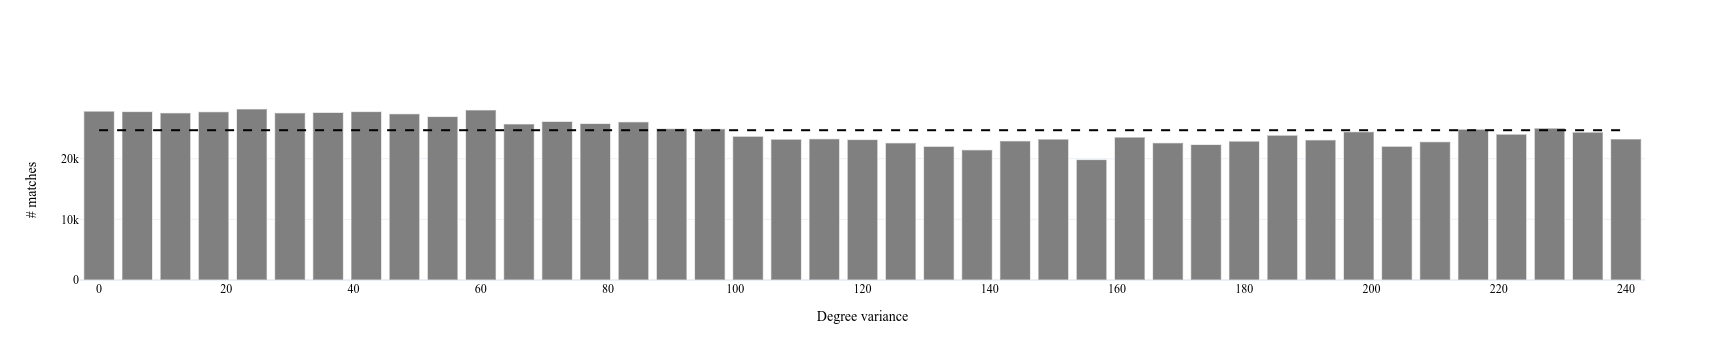

In [5]:
fig = go.Figure()
# plot structure
fig.add_trace(go.Bar(
    x=dfg['Variance'],
    y=dfg['HomeTeam'],
    marker_color='gray'
))

fig.add_trace(go.Scatter(
    x=dfg["Variance"],
    y=dfg["mean"],
    mode="lines",
    line = dict(color='black', dash='dash')
))
# plot
return_fig_settings(fig, 'Degree variance', '# matches')
fig.update_xaxes(tickmode='linear', tick0=0, dtick=20)
fig.update_layout(showlegend=False)
fig.show(config=config)

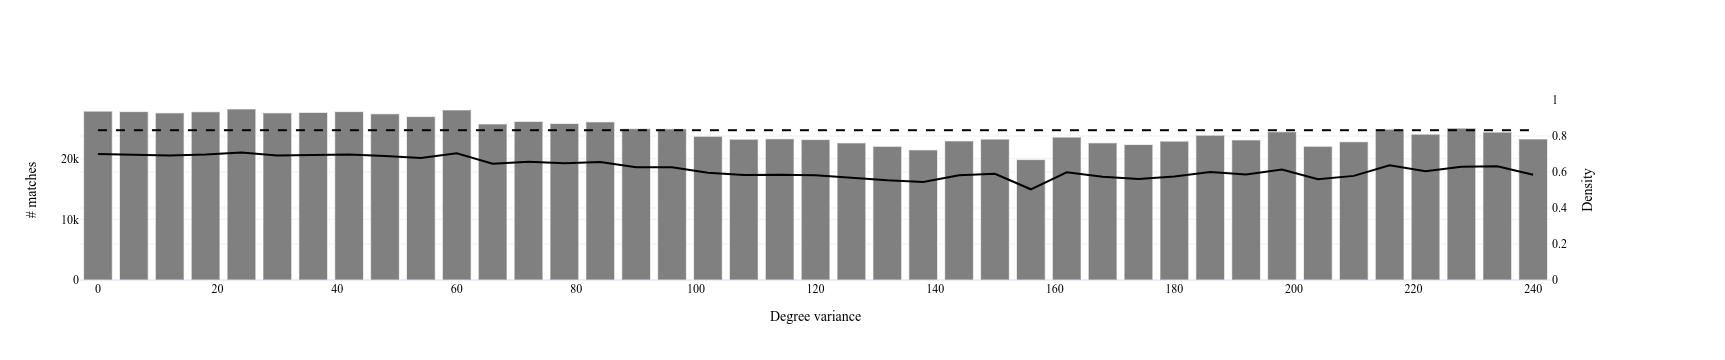

In [6]:
dfg_density=experiment_df[experiment_df.ELO_Rating_K == 15].groupby('Variance', as_index=False).agg({"Density": "mean"})
from plotly.subplots import make_subplots
fig = make_subplots(specs=[[{"secondary_y": True}]])
# plot structure
fig.add_trace(go.Bar(
    x=dfg['Variance'],
    y=dfg['HomeTeam'],
    marker_color='gray'
))

fig.add_trace(go.Scatter(
    x=dfg["Variance"],
    y=dfg["mean"],
    mode="lines",
    line = dict(color='black', dash='dash')
))
fig.add_trace(go.Scatter(
    x=dfg_density["Variance"],
    y=dfg_density["Density"],
    mode="lines",
    line = dict(color='black')
),secondary_y=True)
# plot
return_fig_settings(fig, 'Degree variance', '# matches')
fig.update_xaxes(tickmode='linear', tick0=0, dtick=20)

fig.update_yaxes(title_text="Density", range=[0.0, 1.0], secondary_y=True)
fig.update_layout(showlegend=False)
fig.show(config=config)

#### Team ratings differences

Comparing how True and ELO rating rate the matchup and also how far the elo rating is from the true values.

In [7]:
experiment_df['TrueDiff'] = experiment_df['HomeRating'] - experiment_df['AwayRating']
experiment_df['ELODiff'] = experiment_df['Home_elo_rating'] - experiment_df['Away_elo_rating']
experiment_df['RatingError'] = abs(experiment_df['TrueDiff'].abs() - experiment_df['ELODiff'].abs())

In [8]:
experiment_df['HomeDiff'] = abs(experiment_df['HomeRating'] - experiment_df['Home_elo_rating'])
experiment_df['AwayDiff'] = abs(experiment_df['AwayRating'] - experiment_df['Away_elo_rating'])
experiment_df['TotalDiff'] = experiment_df['HomeDiff'].abs() + experiment_df['AwayDiff'].abs()
experiment_df["TeamDiff"] = (experiment_df["HomeDiff"].abs() + experiment_df["AwayDiff"].abs()) / 2

Team diff is the average of AwayDiff and HomeDiff

In [9]:
experiment_df[["HomeDiff", "AwayDiff", "TeamDiff"]].head()

HomeDiff  AwayDiff  TeamDiff
0   50.0831  187.0691  118.5761
1   22.9202   24.0573   23.4887
2   52.1836   49.8013   50.9925
3  257.7080   14.8516  136.2798
4    0.4989   16.0423    8.2706

#### Adding degree information

In [10]:
aux_df = experiment_df[experiment_df["ELO_Rating_K"] == 15]
home_degree = aux_df[['Variance', 'HomeTeam']].value_counts().to_frame('counts').to_dict()["counts"]
away_degree = aux_df[['Variance', 'AwayTeam']].value_counts().to_frame('counts').to_dict()["counts"]
for k,v in away_degree.items():
    home_degree[k] = home_degree.get(k, 0) + v

In [11]:
experiment_df["HomeDegree"] = [home_degree.get((v, t), 0) for v,t in tuple(zip(experiment_df["Variance"], experiment_df["HomeTeam"]))]
experiment_df["AwayDegree"] = [home_degree.get((v, t), 0) for v,t in tuple(zip(experiment_df["Variance"], experiment_df["AwayTeam"]))]

For every variance, we categorise the degrees in 10 grups

In [12]:
experiment_df["HomeDegreeGroup"] = experiment_df.groupby(['Variance'])['HomeDegree'].transform(lambda x: pd.qcut(x, q=[0, 0.1, 0.9, 1.0], labels=["low_degree", "medium_group", "high_degree"]))
experiment_df["AwayDegreeGroup"] = experiment_df.groupby(['Variance'])['AwayDegree'].transform(lambda x: pd.qcut(x, q=[0, 0.1, 0.9, 1.0], labels=["low_degree", "medium_group", "high_degree"]))

In [ ]:
experiment_df[experiment_df.Variance == 234].groupby("AwayDegreeGroup").agg({"AwayDegree": "mean"})

In [13]:
experiment_df["TotalDegree"] = experiment_df["HomeDegree"] + experiment_df["AwayDegree"]
experiment_df["TotalDegreeGroup"] = experiment_df.groupby(['Variance'])['TotalDegree'].transform(lambda x: pd.qcut(x, q=[0, 0.1, 0.9, 1.0], labels=["low_degree", "medium_group", "high_degree"]))

In [21]:
#experiment_df[(experiment_df["Variance"] == 240)][["HomeTeam", "AwayTeam", "HomeDegree", "AwayDegree"]].describe()
#experiment_df.groupby("Variance").agg({"HomeDegree": ["mean", "min", "max"], "AwayDegree": ["mean", "min", "max"]})
experiment_df[["HomeDegree", "HomeDegreeGroup", "AwayDegree", "AwayDegreeGroup", "TotalDegree", "TotalDegreeGroup"]]

HomeDegree HomeDegreeGroup  AwayDegree AwayDegreeGroup  TotalDegree  \
0                282    medium_group         272    medium_group          554   
1                256      low_degree         278    medium_group          534   
2                292    medium_group         288    medium_group          580   
3                266    medium_group         286    medium_group          552   
4                298     high_degree         260      low_degree          558   
...              ...             ...         ...             ...          ...   
26334771          42      low_degree         318    medium_group          360   
26334772         186    medium_group         318    medium_group          504   
26334773         230    medium_group         308    medium_group          538   
26334774         334    medium_group         334    medium_group          668   
26334775          72      low_degree         190    medium_group          262   

         TotalDegreeGroup  
0            medium_group  
1            medium_group  
2            medium_group  
3            medium_group  
4            medium_group  
...                   ...  
26334771       low_degree  
26334772     medium_group  
26334773     medium_group  
26334774      high_degree  
26334775       low_degree  

[26334776 rows x 6 columns]

### Optimal K for density values

#### Split of data

The 10 first rounds are used as a rating initialisation. After that a third of the rounds is used as in_sample evaluation

In [14]:
init_dict = {}
split_dict = {}
for index, item in experiment_df.groupby("Variance").agg({'Round': 'max'})['Round'].items():
    split_dict[index] = int(item * 0.5)
    init_dict[index] = int(item * 0.2)
experiment_df['Init_Rounds'] = experiment_df['Variance'].map(init_dict)
experiment_df['Split_Rounds'] = experiment_df['Variance'].map(split_dict)

In [15]:
in_sample = experiment_df[(experiment_df.Round > experiment_df.Init_Rounds) & (experiment_df.Round <=  experiment_df.Split_Rounds)]
in_sample

Unnamed: 0  HomeTeam  AwayTeam  Season  Round Result  \
5594            5594       180         0       0     80   home   
5595            5595        39       100       0     80   home   
5596            5596        38         1       0     80   home   
5597            5597        40       101       0     80   away   
5598            5598        37         2       0     80   home   
...              ...       ...       ...     ...    ...    ...   
26323144    11985080       188        90       0    198   home   
26323145    11985081       190        92       0    198   home   
26323146    11985082       191        93       0    198   home   
26323147    11985083       192        94       0    198   home   
26323148    11985084       193        95       0    198   draw   

            TrueForecast CalculatedForecast  ELO_Rating_K  Variance  Density  \
5594      0.66-0.21-0.14     0.61-0.23-0.16            15         0   0.6997   
5595      0.34-0.29-0.37     0.42-0.29-0.29            15         0   0.6997   
5596      0.59-0.24-0.17     0.46-0.28-0.26            15         0   0.6997   
5597      0.48-0.27-0.24     0.49-0.27-0.24            15         0   0.6997   
5598      0.59-0.24-0.17     0.59-0.24-0.17            15         0   0.6997   
...                  ...                ...           ...       ...      ...   
26323144  0.56-0.25-0.19     0.80-0.13-0.07            65       240   0.5843   
26323145  0.52-0.26-0.22     0.52-0.26-0.22            65       240   0.5843   
26323146  0.40-0.29-0.31     0.42-0.29-0.29            65       240   0.5843   
26323147  0.22-0.26-0.52     0.20-0.25-0.55            65       240   0.5843   
26323148  0.36-0.29-0.35     0.62-0.22-0.15            65       240   0.5843   

          RealDegree  RealVariance    RPS  Likelihood  ForecastError  \
5594        278.4800       12.5718 0.0887     -0.4931         0.0013   
5595        278.4800       12.5718 0.2117     -0.8684         0.0058   
5596        278.4800       12.5718 0.1776     -0.7697         0.0125   
5597        278.4800       12.5718 0.4051     -1.4189         0.0000   
5598        278.4800       12.5718 0.0971     -0.5213         0.0000   
...              ...           ...    ...         ...            ...   
26323144    232.5400      102.0288 0.0225     -0.2235         0.0359   
26323145    232.5400      102.0288 0.1406     -0.6593         0.0000   
26323146    232.5400      102.0288 0.2095     -0.8621         0.0003   
26323147    232.5400      102.0288 0.4689     -1.6083         0.0006   
26323148    232.5400      102.0288 0.2058     -1.5008         0.0550   

          ExpectedRPS  Forecastability  HomeRating  AwayRating  \
5594           0.1730           0.1716   1071.8569    914.0736   
5595           0.2344           0.2286    983.0462   1042.5576   
5596           0.2038           0.1912    931.7400    818.0302   
5597           0.2171           0.2171    974.8337    936.3588   
5598           0.1924           0.1924   1121.2889   1010.4356   
...               ...              ...         ...         ...   
26323144       0.2363           0.2004    989.9715    899.3340   
26323145       0.2095           0.2094   1038.8746    974.0738   
26323146       0.2273           0.2269    990.9113   1006.1739   
26323147       0.2113           0.2106    847.5005   1008.5794   
26323148       0.2837           0.2288    944.6733    993.0178   

          Home_elo_rating  Away_elo_rating  TrueDiff   ELODiff  RatingError  \
5594            1056.5802         931.5360  157.7833  125.0442      32.7391   
5595             977.6438         981.7072  -59.5114   -4.0633      55.4481   
5596             910.5912         885.2164  113.7099   25.3748      88.3351   
5597            1001.4013         961.0937   38.4749   40.3076       1.8327   
5598            1085.4736         972.2060  110.8534  113.2675       2.4141   
...                   ...              ...       ...       ...          ...   
26323144        1070.2432         789.4673   

In [16]:
in_sample.ELO_Rating_K.unique()

array([15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47,
       49, 51, 53, 55, 57, 59, 61, 63, 65])

Optimizing the K by RPS but it could be done for other

In [17]:
optimizer = 'RPS'
in_sample_agg = in_sample.groupby(['Variance', 'ELO_Rating_K'], as_index=False).agg({'RPS': 'mean', 'RatingError': 'mean'})
optimal_k_df = in_sample_agg[in_sample_agg.groupby(['Variance'])[optimizer].transform(min) == in_sample_agg[optimizer]]
optimal_k_df.head()

Variance  ELO_Rating_K    RPS  RatingError
0           0            15 0.2057      39.6891
27          6            17 0.1997      42.5909
53         12            17 0.2067      40.3390
79         18            17 0.2056      41.0505
105        24            17 0.2025      40.0475

In [18]:
config = {
    'toImageButtonOptions': {
        'format': 'svg', # one of png, svg, jpeg, webp
        'filename': 'figure',
        "height": 600,
        "width": 800,
        'scale': 1 # Multiply title/legend/axis/canvas sizes by this factor
    }
}
def return_fig_settings(fig_instance, x_title, y_title):
    fig_instance.update_layout(
        xaxis_title=x_title,
        yaxis_title=y_title,
        legend=dict(
            font=dict(
                family='Times New Roman',
                size=15,
                color="Black"
            ),
            orientation='h',
            bordercolor="Black",
            borderwidth=2,
            yanchor="bottom",
            xanchor='right',
            x=1,
            y=1
        )
    )
    font_dict = dict(
        family='Times New Roman',
        size=15,
        color='black'
    )
    fig_instance.update_layout(
        font=font_dict,  # font formatting
        plot_bgcolor='white',  # background color
    )

/home/marc/anaconda3/envs/dfg_rating/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



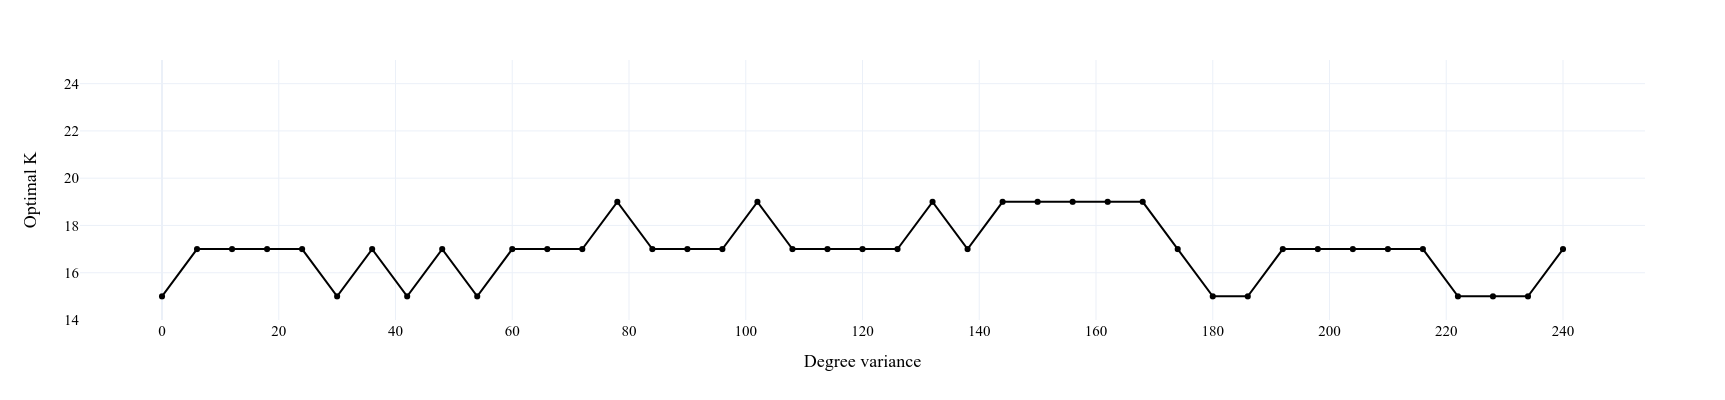

In [19]:
optimal_k_df["color"] = "black"
fig = px.line(
    optimal_k_df, x='Variance', y='ELO_Rating_K', color="color",
    color_discrete_map={"black": "black"},
    markers=True,
    labels={
        "ELO_Rating_K": "K"
    },
    width=800, height=400
)
return_fig_settings(fig, "Degree variance", "Optimal K")
fig.update_yaxes(range=[14, 25])
fig.update_xaxes(tickmode='linear', tick0=0, dtick=20)
fig.update_layout(showlegend=False)
fig.show(config=config)

In [ ]:
def optimal_k(df, optimizer="RPS"):
    in_sample = df[(df.Round > df.Init_Rounds) & (df.Round <=  df.Split_Rounds)]
    in_sample_agg = in_sample.groupby(['Variance', 'ELO_Rating_K'], as_index=False).agg({'RPS': 'mean', 'RatingError': 'mean'})
    optimal_k_df = in_sample_agg[in_sample_agg.groupby(['Variance'])[optimizer].transform(min) == in_sample_agg[optimizer]]
    return optimal_k_df
    

In [20]:
df_optimal = experiment_df.merge(optimal_k_df, on=['Variance', 'ELO_Rating_K'], how='inner', suffixes=["", "_IS"])
df_optimal = df_optimal[df_optimal.Round > df_optimal.Split_Rounds]

In [21]:
df_optimal[df_optimal.Variance == 0][["Variance", "HomeDegree", "HomeDegreeGroup", "HomeDiff", "AwayDegree", "AwayDegreeGroup", "AwayDiff", "TeamDiff"]]

Variance  HomeDegree HomeDegreeGroup  HomeDiff  AwayDegree  \
13924         0         272    medium_group    8.8745         282   
13925         0         278    medium_group   34.0468         256   
13926         0         288    medium_group   31.1276         292   
13927         0         286    medium_group    9.3661         266   
13928         0         260      low_degree    3.4385         298   
...         ...         ...             ...       ...         ...   
27843         0         276    medium_group    6.7984         288   
27844         0         282    medium_group   27.8892         272   
27845         0         282    medium_group   37.5007         264   
27846         0         276    medium_group    3.9647         274   
27847         0         298     high_degree    0.4633         266   

      AwayDegreeGroup  AwayDiff  TeamDiff  
13924    medium_group   43.5202   26.1974  
13925      low_degree    7.6227   20.8348  
13926    medium_group   25.3746   28.2511  
13927    medium_group   95.6060   52.4861  
13928     high_degree    1.7403    2.5894  
...               ...       ...       ...  
27843    medium_group    5.9793    6.3888  
27844    medium_group   42.1771   35.0332  
27845      low_degree   29.3894   33.4451  
27846    medium_group   68.5735   36.2691  
27847    medium_group   40.6913   20.5773  

[13924 rows x 8 columns]

In [22]:
home_team_results = df_optimal.groupby(['Variance', 'ELO_Rating_K', "HomeDegreeGroup"]).agg(team_diff=("HomeDiff", np.mean)).reset_index().dropna().rename(columns={"HomeDegreeGroup": "TeamDegreeGroup"})
away_team_results = df_optimal.groupby(['Variance', 'ELO_Rating_K', "AwayDegreeGroup"]).agg(team_diff=("AwayDiff", np.mean)).reset_index().dropna().rename(columns={"AwayDegreeGroup": "TeamDegreeGroup"})
team_results = pd.concat([home_team_results, away_team_results]).groupby(['Variance', "TeamDegreeGroup"], as_index=False).agg(team_diff=("team_diff", np.mean), ELO_Rating_K=("ELO_Rating_K", "first"))
team_results[team_results.Variance == 156]


Variance TeamDegreeGroup  team_diff  ELO_Rating_K
78       156      low_degree    36.5985            19
79       156    medium_group    28.9264            19
80       156     high_degree    31.4418            19

In [52]:
team_results_all = pd.concat([home_team_results, away_team_results]).groupby(['Variance'], as_index=False).agg(team_diff=("team_diff", np.mean), ELO_Rating_K=("ELO_Rating_K", "first"))

In [46]:
test_df = experiment_df.groupby(['Variance', 'Round']).agg({'HomeRating': ['mean', 'std']})
test_df.loc[156]

HomeRating         
            mean      std
Round                    
0      1002.2067  82.2468
1       979.4691 105.1286
2      1014.3098  95.0149
3       971.2935 102.3879
4      1015.3683  86.3247
...          ...      ...
393     953.5111 110.2110
394    1023.0554  81.7789
395     957.9861 109.9889
396    1012.3338  97.1618
397     974.4378 129.8210

[398 rows x 2 columns]

In [23]:
result_df experiment_dfoptimal.groupby(['Variance', 'ELO_Rating_K'],dropna=True).agg(
    {'RPS': np.mean, 'Likelihood': np.mean, 'ForecastError': np.mean, 'ExpectedRPS': np.mean, 'Forecastability': np.mean,'RatingError': np.mean, 'TotalDiff': np.mean, "TeamDiff": np.mean}
)
result_df = result_df.reset_index().dropna()
result_df[result_df.Variance == 156]

Variance  ELO_Rating_K    RPS  Likelihood  ForecastError  ExpectedRPS  \
26       156            19 0.2033     -0.9913         0.0042       0.2019   

    Forecastability  RatingError  TotalDiff  TeamDiff  
26           0.1977      38.5342    59.8473   29.9237

In [24]:
result_df_with_quantiles = df_optimal.groupby(['Variance', 'ELO_Rating_K', "TotalDegreeGroup"],dropna=True).agg(
    {'HomeTeam': 'count', 'RPS': np.mean, 'Likelihood': np.mean, 'ForecastError': np.mean, 'ExpectedRPS': np.mean, 'Forecastability': np.mean,'RatingError': np.mean, 'TotalDiff': np.mean, "TeamDiff": np.mean}
)
result_df_with_quantiles = result_df_with_quantiles.reset_index().dropna()
result_df_with_quantiles[result_df_with_quantiles.Variance == 156]

Variance  ELO_Rating_K TotalDegreeGroup  HomeTeam    RPS  Likelihood  \
240       156            19       low_degree      1011 0.2082     -1.0120   
241       156            19     medium_group      7971 0.2045     -0.9949   
242       156            19      high_degree       946 0.1881     -0.9386   

     ForecastError  ExpectedRPS  Forecastability  RatingError  TotalDiff  \
240         0.0060       0.2071           0.2011      43.8073    69.3359   
241         0.0040       0.2019           0.1979      37.6032    58.4144   
242         0.0042       0.1961           0.1919      40.7428    61.7810   

     TeamDiff  
240   34.6679  
241   29.2072  
242   30.8905

In [25]:
df_optimal[(df_optimal.Variance == 156) & (df_optimal.TotalDegreeGroup == "high_degree")]

Unnamed: 0  HomeTeam  AwayTeam  Season  Round Result    TrueForecast  \
673671     2968769        11       111       0    199   away  0.23-0.27-0.51   
673678     2968776        23       123       0    199   draw  0.49-0.27-0.24   
673705     2968803        75       175       0    199   away  0.21-0.26-0.53   
673723     2968821       113        11       0    200   away  0.52-0.26-0.22   
673736     2968834       132        30       0    200   draw  0.40-0.29-0.31   
...            ...       ...       ...     ...    ...    ...             ...   
683561     2978659        25       123       0    397   home  0.65-0.21-0.14   
683568     2978666        46       144       0    397   away  0.26-0.28-0.46   
683571     2978669        58       156       0    397   away  0.12-0.19-0.69   
683573     2978671        61       159       0    397   home  0.68-0.20-0.13   
683591     2978689        97       195       0    397   away  0.45-0.28-0.27   

       CalculatedForecast  ELO_Rating_K  Variance  Density  RealDegree  \
673671     0.27-0.28-0.46            19       156   0.5039    199.5578   
673678     0.52-0.26-0.22            19       156   0.5039    199.5578   
673705     0.29-0.29-0.42            19       156   0.5039    199.5578   
673723     0.38-0.29-0.33            19       156   0.5039    199.5578   
673736     0.52-0.26-0.21            19       156   0.5039    199.5578   
...                   ...           ...       ...      ...         ...   
683561     0.62-0.22-0.15            19       156   0.5039    199.5578   
683568     0.18-0.24-0.58            19       156   0.5039    199.5578   
683571     0.11-0.18-0.72            19       156   0.5039    199.5578   
683573     0.62-0.23-0.16            19       156   0.5039    199.5578   
683591     0.43-0.28-0.29            19       156   0.5039    199.5578   

        RealVariance    RPS  Likelihood  ForecastError  ExpectedRPS  \
673671      100.4449 0.1836     -0.7873         0.0020       0.2149   
673678      100.4449 0.1602     -1.3419         0.0009       0.2169   
673705      100.4449 0.2085     -0.8594         0.0084       0.2168   
673723      100.4449 0.2967     -1.1095         0.0158       0.2260   
673736      100.4449 0.1606     -1.3434         0.0121       0.2392   
...              ...    ...         ...            ...          ...   
683561      100.4449 0.0824     -0.4712         0.0005       0.1737   
683568      100.4449 0.1039     -0.5437         0.0112       0.2324   
683571      100.4449 0.0463     -0.3351         0.0003       0.1588   
683573      100.4449 0.0853     -0.4815         0.0021       0.1669   
683591      100.4449 0.3470     -1.2518         0.0003       0.2227   

        Forecastability  HomeRating  AwayRating  Home_elo_rating  \
673671           0.2129    848.8878   1002.4217         871.0411   
673678           0.2160    969.0706    926.4480         993.0103   
673705           0.2085    879.7712   1047.5668         866.7730   
673723           0.2103    911.3381    849.1304         830.8722   
673736           0.2271   1152.9473   1169.4111        1175.3374   
...                 ...         ...         ...              ...   
683561           0.1732   1145.0352    990.6555        1125.4000   
683568           0.2211    924.3879   1045.6511         907.4880   
683571           0.1584    842.7638   1128.1930         817.3404   
683573           0.1648   1216.7449   1044.5086        1160.0625   
683591           0.2224   1021.3796   1006.3785         980.3471   

        Away_elo_rating  TrueDiff   ELODiff  RatingError  HomeDiff  AwayDiff  \
673671         991.0150 -153.5339 -119.9740      33.5600   22.1533   11.4067   
673678         927.3568   42.6226   65.6536      23.0310   23.9398    0.9088   
673705         965.2993 -167.7957  -98.5263      69.2694   12.9982   82.2676   
673723         862.6293   62.2077  -31.7571      30.4507   80.4659   13.4989   
673736        1108.9009  -16.4638   66.4365      49.9727   22.3901   60.5102   
...     

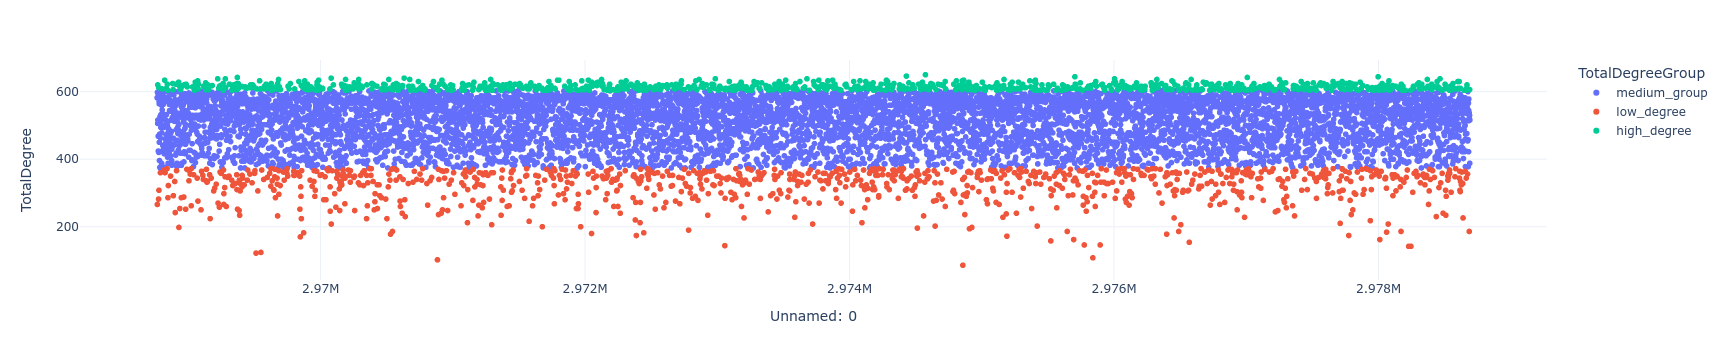

In [26]:
plot_df = df_optimal[df_optimal.Variance == 156]
fig = px.scatter(
    plot_df,
    x="Unnamed: 0",
    y="TotalDegree",
    color="TotalDegreeGroup"
)

fig.show()

### Analysis Out of Sample

In [27]:
config = {
    'toImageButtonOptions': {
        'format': 'svg', # one of png, svg, jpeg, webp
        'filename': 'figure',
        "height": 400,
        "width": 800,
        'scale': 1 # Multiply title/legend/axis/canvas sizes by this factor
    }
}
def return_fig_settings(fig_instance, x_title, y_title):
    fig_instance.update_layout(
        xaxis_title=x_title,
        yaxis_title=y_title,
        legend=dict(
            font=dict(
                family='Times New Roman',
                size=15,
                color="Black"
            ),
            orientation='h',
            bordercolor="Black",
            borderwidth=2,
            yanchor="bottom",
            xanchor='right',
            x=1,
            y=1
        )
    )
    font_dict = dict(
        family='Times New Roman',
        size=15,
        color='black'
    )
    fig_instance.update_layout(
        font=font_dict,  # font formatting
        plot_bgcolor='white',  # background color
    )

#### RPS based metrics

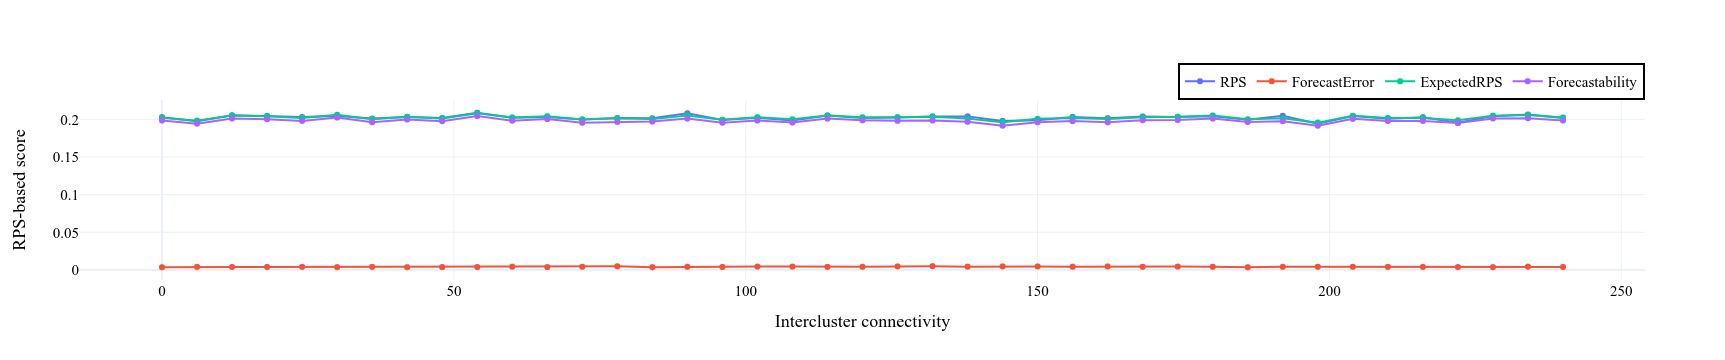

In [28]:
result_df["color"] = "black"
fig = go.Figure()
for rps_based_metric in ["RPS", "ForecastError", "ExpectedRPS", "Forecastability"]:
    fig.add_trace(
        go.Scatter(
            y=result_df[rps_based_metric],
            x=result_df["Variance"],
            mode="lines+markers",
            name=rps_based_metric
        )
    )
return_fig_settings(fig, "Intercluster connectivity", "RPS-based score")
fig.update_layout(showlegend=True)
fig.show(config=config)

/home/marc/anaconda3/envs/dfg_rating/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



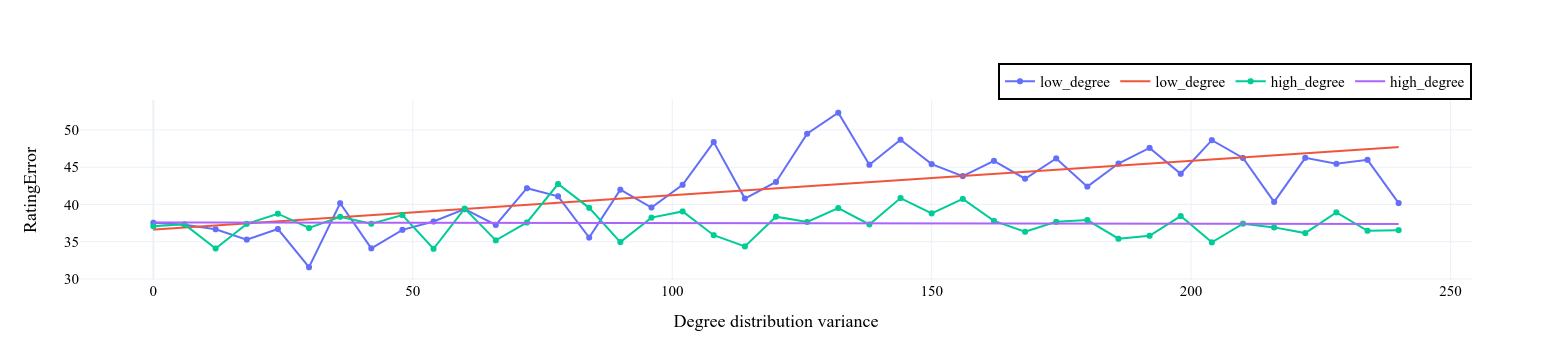

In [47]:
fig = go.Figure()
target = "RatingError"
for name in ["low_degree", "high_degree"]:
    df = result_df_with_quantiles[result_df_with_quantiles["TotalDegreeGroup"] == name]
    df['bestfit'] = sm.OLS(df[target], sm.add_constant(df['Variance'])).fit().fittedvalues
    fig.add_traces([
        go.Scatter(
            x=df["Variance"],
            y=df[target],
            mode='lines+markers',
            name=name
        ),
        go.Scatter(
            x=df["Variance"],
            y=df['bestfit'],
            mode='lines',
            name=name
        ),
    ])
return_fig_settings(fig, "Degree distribution variance", target)
fig.update_layout(showlegend=True)
fig.show(config=config)

#### Team level analysis

In [50]:
team_results

Variance TeamDegreeGroup  team_diff  ELO_Rating_K
0           0      low_degree    30.7528            15
1           0    medium_group    26.2865            15
2           0     high_degree    32.0607            15
3           6      low_degree    27.1245            17
4           6    medium_group    29.5659            17
..        ...             ...        ...           ...
118       234    medium_group    28.9277            15
119       234     high_degree    30.7225            15
120       240      low_degree    31.9833            17
121       240    medium_group    28.4520            17
122       240     high_degree    26.8452            17

[123 rows x 4 columns]

/home/marc/anaconda3/envs/dfg_rating/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



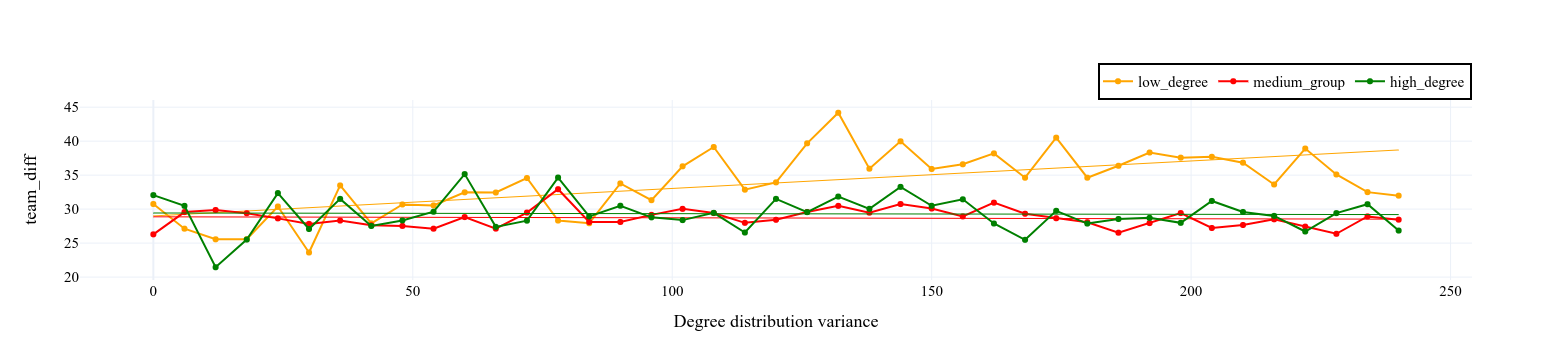

In [51]:
fig = go.Figure()
target = "team_diff"
for name, color in [("low_degree", "orange"), ("medium_group", "red"), ("high_degree", "green")]:
    df = team_results[team_results["TeamDegreeGroup"] == name]
    df['bestfit'] = sm.OLS(df[target], sm.add_constant(df['Variance'])).fit().fittedvalues
    fig.add_traces([
        go.Scatter(
            x=df["Variance"],
            y=df[target],
            mode='lines+markers',
            legendgroup=name,
            name=name,
            line={
                "color": f"{color}",
                "width": 2
            }
        ),
        go.Scatter(
            x=df["Variance"],
            y=df['bestfit'],
            mode='lines',
            legendgroup=name,
            name=name + "bestfit",
            showlegend=False,
            line={
                "color": f"{color}",
                "width": 1
            }
        )
    ])
return_fig_settings(fig, "Degree distribution variance", target)
#fig.update_yaxes(range=[0.165, 0.225])
fig.update_layout(showlegend=True)
fig.show(config=config)

Team diff for all degrees

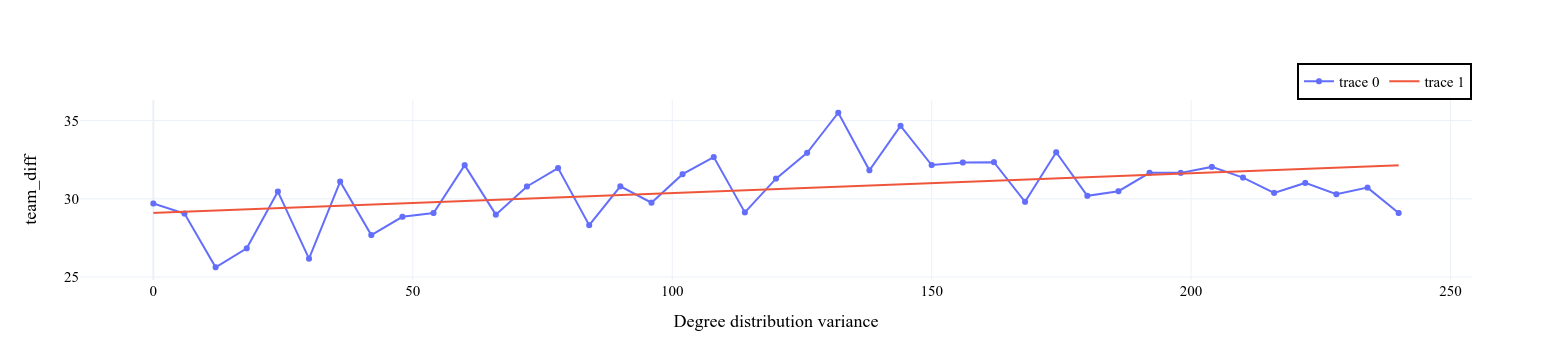

In [56]:
fig = go.Figure()
target= "team_diff"
team_results_all['bestfit'] = sm.OLS(team_results_all[target], sm.add_constant(team_results_all['Variance'])).fit().fittedvalues
fig.add_traces([
    go.Scatter(
        x=team_results_all["Variance"],
        y=team_results_all[target],
        mode='lines+markers',
    ),
    go.Scatter(
        x=team_results_all["Variance"],
        y=team_results_all['bestfit'],
        mode='lines',
    )
])
return_fig_settings(fig, "Degree distribution variance", target)
#fig.update_yaxes(range=[0.165, 0.225])
fig.update_layout(showlegend=True)
fig.show(config=config)

### Bar plots with confidence intervals

In [ ]:
x = result_df['Variance']
y_upper = [t[1] for t in result_df["RPS_bootstrap"]]
y_lower = [t[0] for t in result_df[("RPS_bootstrap")]]

fig = go.Figure([
    go.Scatter(
        x=x,
        y=result_df["RPS_mean"],
        line=dict(color='rgb(0,100,80)'),
        mode='lines'
    ),
    go.Scatter(
        x=pd.concat([x,x[::-1]]), # x, then x reversed
        y=y_upper+y_lower[::-1], # upper, then lower reversed
        fill='toself',
        fillcolor='rgba(0,100,80,0.2)',
        line=dict(color='rgba(255,255,255,0)'),
        hoverinfo="skip",
        showlegend=False
    )
])
fig.update_yaxes(range=[0.15, 0.25])
fig.show()

In [ ]:
x = result_df['Variance']
y_upper = [t[1] for t in result_df["RatingError_bootstrap"]]
y_lower = [t[0] for t in result_df[("RatingError_bootstrap")]]

fig = go.Figure([
    go.Scatter(
        x=x,
        y=result_df["RatingError_mean"],
        line=dict(color='rgb(0,100,80)'),
        mode='lines'
    ),
    go.Scatter(
        x=pd.concat([x,x[::-1]]), # x, then x reversed
        y=y_upper+y_lower[::-1], # upper, then lower reversed
        fill='toself',
        fillcolor='rgba(0,100,80,0.2)',
        line=dict(color='rgba(255,255,255,0)'),
        hoverinfo="skip",
        showlegend=False
    )
])

fig.update_yaxes(range=[0, 400])
fig.show()

In [ ]:
x = result_df['Variance']
y_upper = [t[1] for t in result_df["TotalDiff_bootstrap"]]
y_lower = [t[0] for t in result_df[("TotalDiff_bootstrap")]]

fig = go.Figure([
    go.Scatter(
        x=x,
        y=result_df["TotalDiff_mean"],
        line=dict(color='rgb(0,100,80)'),
        mode='lines'
    ),
    go.Scatter(
        x=pd.concat([x,x[::-1]]), # x, then x reversed
        y=y_upper+y_lower[::-1], # upper, then lower reversed
        fill='toself',
        fillcolor='rgba(0,100,80,0.2)',
        line=dict(color='rgba(255,255,255,0)'),
        hoverinfo="skip",
        showlegend=False
    )
])
fig.update_yaxes(range=[0, 200])
fig.show()